In [1]:
from ema_workbench import Scenario, Policy, MultiprocessingEvaluator, ema_logging, load_results, save_results
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.analysis import parcoords
import seaborn as sns

In [2]:
ACTORNAME = "Gorssel"
dike_model, planning_steps = get_model_for_problem_formulation(ACTORNAME)
outcomekeys = [outcome.name for outcome in dike_model.outcomes]

# Scenario selection

In [3]:
ACTOR = "genscen_Gorssel_50000_09-06-2021-01-38-16.tar.gz"
experiments, outcomes = load_results("data/generated/" + ACTOR)
outcomes_df = pd.DataFrame(outcomes)

In [4]:
outcomes_df.columns.values.tolist()

['Difference in Expected Annual Damage Gorssel-Deventer',
 'Difference in Expected Number of Deaths Gorssel-Deventer',
 'Gorssel Expected Annual Damage',
 'Gorssel Expected Number of Deaths',
 'Total Costs of Policies']

In [5]:
DAMAGE = outcomes_df.columns[2]
DEATHS = outcomes_df.columns[3]
COSTS = outcomes_df.columns[4]

In [6]:
results = pd.concat([experiments, outcomes_df], axis=1)

In [7]:
worst_damage_df = results.loc[results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=90)]
worst_deaths_df = results.loc[results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=90)]
worst_cost_df = results.loc[results[COSTS] > np.percentile(a=outcomes[COSTS], q=90)]
worst_ix =set(worst_damage_df["scenario"].tolist()) & set(worst_deaths_df["scenario"].tolist()) & set(worst_cost_df["scenario"].tolist())

In [8]:
worst_case = results.iloc[list(worst_ix)].sample(n=1, random_state=1)

In [9]:
best_damage_df = results.loc[results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=10)]
best_deaths_df = results.loc[results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=10)]
best_cost_df = results.loc[results[COSTS] <= np.percentile(a=outcomes[COSTS], q=10)]
best_ix = set(best_damage_df["scenario"].tolist()) & set(best_deaths_df["scenario"].tolist()) & set(best_cost_df["scenario"].tolist())

In [10]:
best_case = results.iloc[list(best_ix)].sample(n=1, random_state=1)

In [11]:
middle_damage_df = results.loc[(results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=45)) & (results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=55))]
middle_deaths_df = results.loc[(results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=45)) & (results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=55))]
middle_cost_df = results.loc[(results[COSTS] > np.percentile(a=outcomes[COSTS], q=45)) & (results[COSTS] <= np.percentile(a=outcomes[COSTS], q=55))]
middle_ix =set(middle_damage_df["scenario"].tolist()) & set(middle_deaths_df["scenario"].tolist()) & set(middle_cost_df["scenario"].tolist())

In [12]:
middle_case = results.iloc[list(middle_ix)].sample(n=1, random_state=1)

In [13]:
uncertainties =list(dike_model.uncertainties._data.keys())

In [14]:
selected = pd.concat([middle_case.loc[:, uncertainties], best_case.loc[:, uncertainties], worst_case.loc[:, uncertainties]], axis=0)

In [15]:
cases = {0: "middle", 1: "best", 2: "worst"}

In [16]:
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

# Optimisation

In [17]:
hypervolumemin = [0,0,0]
hypervolumemax = outcomes_df[outcomekeys[2:]].max(axis=0).values.tolist()

In [18]:
ema_logging.log_to_stderr(ema_logging.INFO)

nfe = 3000 + 1000

def optimize(scenario, nfe, model, converge_metrics, epsilons):


    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario, convergence_freq=200)
    return results, convergence


results = []
for scenario in scenarios:
    convergence_metrics = [HyperVolume(minimum=hypervolumemin, maximum=hypervolumemax),
                           EpsilonProgress()]
    epsilons = [1e3] * len(outcomekeys[2:])
    
    
    
    results.append(optimize(scenario, nfe, dike_model, convergence_metrics, epsilons))


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/4000 nfe
[MainProcess/INFO] generation 5: 499/4000 nfe
[MainProcess/INFO] generation 10: 997/4000 nfe
[MainProcess/INFO] generation 15: 1495/4000 nfe
[MainProcess/INFO] generation 20: 1968/4000 nfe
[MainProcess/INFO] generation 25: 2418/4000 nfe
[MainProcess/INFO] generation 30: 2861/4000 nfe
[MainProcess/INFO] generation 35: 3327/4000 nfe
[MainProcess/INFO] generation 40: 3770/4000 nfe
[MainProcess/INFO] optimization completed, found 6 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/4000 nfe
[MainProcess/INFO] generation 5: 496/4000 nfe
[MainProcess/INFO] generation 10: 989/4000 nfe
[MainProcess/INFO] generation 15: 1471/4000 nfe
[MainProcess/INFO] generation 20: 1945/4000 nfe
[MainProcess/INFO] generation 25: 2323/4000 nfe
[MainProcess/INFO] generation 30: 2644/4000 nfe
[MainProcess/INFO] generation 35: 2949/4000 nfe
[MainProcess/INFO] generation 40: 327

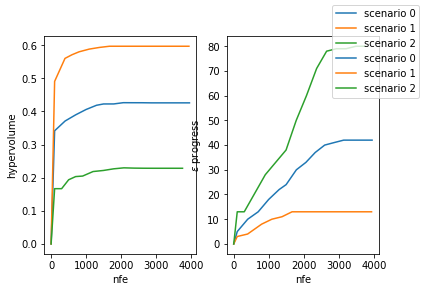

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2,sharex=True)
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

# Saving

In [20]:
for i, (result, convergence) in enumerate(results):
    result.to_csv("data/optimisation/" + ACTORNAME + "/results_" + cases[i] +".csv", index=False)
    convergence.to_csv("data/optimisation/" + ACTORNAME + "/convergence_" + cases[i] +".csv", index=False)

In [21]:
selected.to_csv("data/optimisation/" + ACTORNAME + "/selected.csv", index=False)

# Reading

In [234]:
read_results = []

for _,case in cases.items():
    temp = pd.read_csv("data/optimisation/" + ACTORNAME + "/results_" + case +".csv")
    temp_ = pd.read_csv("data/optimisation/" + ACTORNAME + "/convergence_" + case +".csv")
    read_results.append([temp, temp_])

In [27]:
opt_df = pd.DataFrame()
for i, (result, convergence) in enumerate(results):
    opt_df = pd.concat([opt_df, result], axis=0)

In [30]:
policyoutcomes = opt_df.loc[:, outcomekeys[2:]]

Below we plot per scenario 

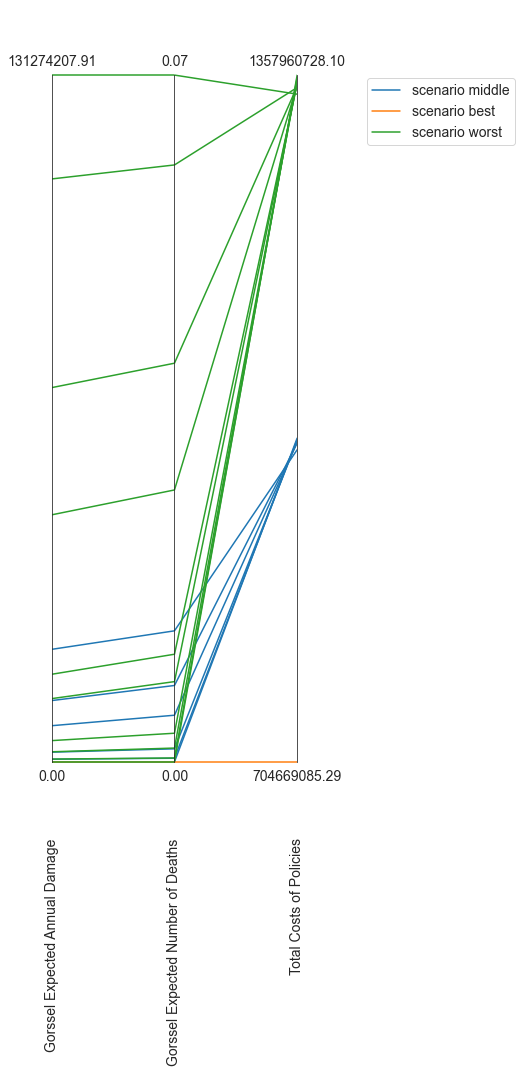

In [32]:
colors = iter(sns.color_palette())
limits = parcoords.get_limits(policyoutcomes)

# limits.loc[0, ['inertia', 'reliability']] = 1
# limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
# limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
# limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.loc[:,  outcomekeys[2:]]
    paraxes.plot(data, label=f'scenario {cases[i]}', color=color)

paraxes.legend()
plt.rcParams["figure.figsize"] = (5,15)
plt.show()


# Re-evaluate under deep uncertainty

In [39]:
levers = [lever.name for lever in dike_model.levers]

In [40]:
policies = []
for i, (result, _) in enumerate(results):
    result = result.loc[:, levers]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {cases[i]} option {j}', **row.to_dict())
        policies.append(policy)

In [41]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    reevaluation_results = evaluator.perform_experiments(1000, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 16 policies * 1 model(s) = 16000 experiments
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 11200 cases completed
[MainProcess/INFO] 12800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 16000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [ ]:
du_experiments, du_outcomes = reevaluation_results

# Saving

In [ ]:
save_results(reevaluation_results, "data/optimisation/du_scen_" + ACTORNAME + ".tar.gz")

# Reading

In [ ]:
du_experiments, du_outcomes = load_results("data/optimisation/du_scen_" + ACTORNAME + ".tar.gz")

## Regret
Comparing alternatives
"With a regret view, a decision maker wants to minimize the regret of choosing incorrectly, where regret is the loss in performance. This regret could be the cost of assuming the wrong future scenario or the cost of choosing the wrong alternative. In the first case, maximum regret of an alternative is the difference between its performances in the best estimate future scenario and in the scenario where it shows the worst performance, for example, as applied by Kasprzyk et al. (2013). In the second case, the regret of an alternative in a certain future scenario is the difference between its performance and the best-performing alternative, as proposed by Savage (1951). Maximum regret of an alternative is its highest regret achieved over all future scenarios. In both regret cases, the alternative with the smallest maximum regret is the most robust."

https://link.springer.com/article/10.1007/s13595-017-0641-2

### Kwakkels stuff - still have to test and adept but laptop sloooow

In [212]:
# I may have accidentally meddled with this. Github is annoying today.

In [213]:
overall_scores = {}
regret = []
for scenario in du_experiments.scenario.unique():
    logical = du_experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in du_outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = du_experiments[du_experiments.scenario==scenario]
    
    best = temp_results.max()
    best['max_P'] = temp_results[outcomekeys[0]].min()
    scenario_regret = scenario - best
    scenario_regret['policy'] = temp_experiments.policy.values
    regret.append(scenario_regret.T)

In [214]:
regret = pd.DataFrame(regret)
regret['policy'] = regret['policy'].astype(str)
maxregret = regret.groupby('policy').max()

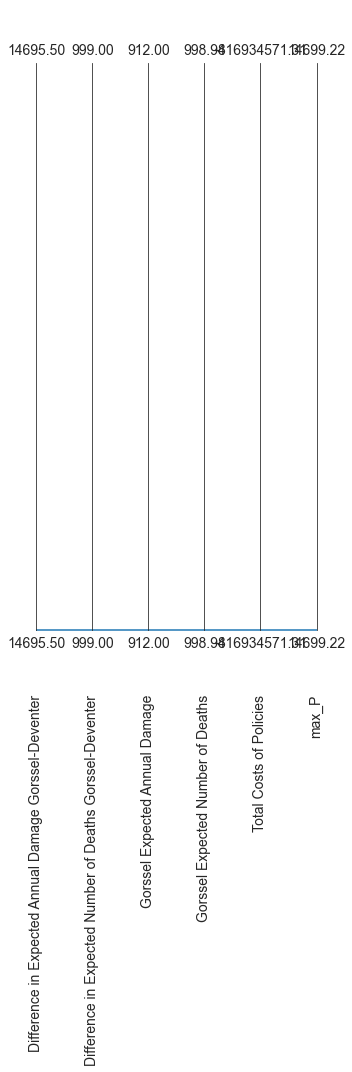

In [215]:
limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)
paraxes.plot(maxregret)
plt.show()

## Satisficing
Performance threshold
"seeks a decision alternative that meets his or her performance requirements over the range of plausible future scenarios. "

In [ ]:
thresholds = {}